# Workshop on Domain-Specific Lanugages for Performance-Portable Weather and Climate Models

## Session 2B: Advanced Concepts II - Solutions

In [1]:
# Add prior directory to system path
import sys
sys.path.append("../")

### 1. Transient diffusion

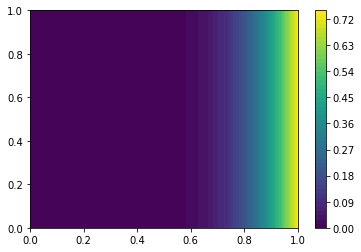

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import gt4py.storage as gt_storage
from gt4py.gtscript import stencil, function, PARALLEL, computation, interval, Field, parallel, region, I, J, K

from tools import print_generated_code

backend = "numpy"
dtype = np.float64

num_cells_1d = 16
nhalo = 1
shape = (num_cells_1d + 2*nhalo, num_cells_1d + 2*nhalo, 1)

dx = 1.0 / (num_cells_1d - 1)
dt = dx * dx / (2 * 1) * 0.9 # Valid timestep for stability

# Storage builder
def make_zeros():
    """Make a new storage for the example."""
    return gt_storage.zeros(backend=backend, shape=shape, dtype=dtype, default_origin=(nhalo, nhalo, 0))

# Plotting
def plot_solution(u):
    """Plot the solution."""
    x = np.linspace(0, 1, num_cells_1d)
    axes = np.meshgrid(x, x)
    plt.contourf(*axes, u.data[nhalo:-nhalo, nhalo:-nhalo, 0], 50)
    plt.colorbar()
    plt.show()

# GT4Py Laplace operator
@function
def laplace(field):
    """Computes (u_xx + u_yy)."""
    xd2 = -2 * field[0, 0, 0] + field[-1, 0, 0] + field[1, 0, 0]
    yd2 = -2 * field[0, 0, 0] + field[0, -1, 0] + field[0, 1, 0]
    return (xd2 + yd2) / (dx * dx)

# GT4Py stencil
@stencil(backend)
def take_timestep(u: Field[dtype]):
    with computation(PARALLEL), interval(...):
        # Left
        with parallel(region[I[0]-1, :]):
            u[0, 0, 0] = u[1, 0, 0]
        
        # Right
        with parallel(region[I[-1] + 1, :]):
            u[0, 0, 0] = u[-1, 0, 0]
            
        # Bottom
        with parallel(region[:, J[0]-1]):
            u[0, 0, 0] = 0.
       
        # Top: not strictly necessary, since the stencil never iterates there
        with parallel(region[:, J[-1] + 1]):
            u[0, 0, 0] = 1.

        # Everywhere
        u += dt * laplace(u)


# Create storage (and set IC implicitly)
u = make_zeros()
for n in range(10):
    take_timestep(u, origin=(1, 1, 0))

plot_solution(u)

### 2. Bi-Laplacian (Distributed Computing)

In [3]:
from gt4py.gtscript import stencil, function, PARALLEL, computation, interval, Field, parallel, region, I, J, K

rank = 0

south_edge = (0 <= rank <= 2)
west_edge = rank % 3 == 0
north_edge = (6 <= rank <= 8)
east_edge = (rank + 1) % 3 == 0

istart = I[0] if west_edge else None
iend = I[-1] if east_edge else None
jstart = J[0] if south_edge else None
jend = J[-1] if north_edge else None

@function
def d2x(u):
    return (-2 * u[0, 0, 0] + u[-1, 0, 0] + u[1, 0, 0]) / (dx * dx)

@function
def d2y(u):
    return (-2 * u[0, 0, 0] + u[0, -1, 0] + u[0, 1, 0]) / (dx * dx)

@function
def lap_cube_cells(u):
    # Not necessary, but helps readability of the code
    from __externals__ import istart, iend, jstart, jend

    u_next = d2x(u) + d2y(u)

    # A practioner of numerical methods should rightly complain that these are committing finite difference crimes,
    # but correcting those would be overly verbose for an example.
    with parallel(region[istart, jstart - 1]):
        u_next = d2y(u) + (-2 * u[0, 0, 0] + u[1, 0, 0] + u[-1, 1, 0]) / (dx * dx)
    with parallel(region[iend, jstart - 1]):
        u_next = d2y(u) + (-2 * u[0, 0, 0] + u[1, 0, 0] + u[1, 1, 0]) / (dx * dx)
    with parallel(region[istart, jend + 1]):
        u_next = d2y(u) + (-2 * u[0, 0, 0] + u[1, 0, 0] + u[-1, -1, 0]) / (dx * dx)
    with parallel(region[iend, jend + 1]):
        u_next = d2y(u) + (-2 * u[0, 0, 0] + u[1, 0, 0] + u[1, -1, 0]) / (dx * dx)

    with parallel(region[istart - 1, jstart]):
        u_next = d2x(u) + (-2 * u[0, 0, 0] + u[0, 1, 0] + u[1, -1, 0]) / (dx * dx)
    with parallel(region[iend + 1, jstart]):
        u_next = d2x(u) + (-2 * u[0, 0, 0] + u[0, 1, 0] + u[-1, -1, 0]) / (dx * dx)
    with parallel(region[istart - 1, jend]):
        u_next = d2x(u) + (-2 * u[0, 0, 0] + u[0, 1, 0] + u[1, 1, 0]) / (dx * dx)
    with parallel(region[iend + 1, jend]):
        u_next = d2x(u) + (-2 * u[0, 0, 0] + u[0, 1, 0] + u[-1, 1, 0]) / (dx * dx)

    return u_next

### 3. Python Decorators

In [4]:
import types
import gt4py
import time

def get_repr(func) -> str:
    if isinstance(func, types.FunctionType):
        return func.__name__
    elif isinstance(func, gt4py.StencilObject):
        return func.definition_func.__name__ + "_" + func._gt_id_
    else:
        raise TypeError("Unrecognized type")
    
def print_all_times():
    for call in times:
        print(f"{call} called {ncalls[call]} times. Total time: {times[call]} secs")
        
times = {}
ncalls = {}

def timeit(func):
    def wrapper():
        start = time.perf_counter()
        func()
        stop = time.perf_counter()
        call = get_repr(func)
        times[call] = times.get(call, 0.0) + stop - start
        ncalls[call] = ncalls.get(call, 0) + 1
    return wrapper

@timeit
def say_whee():
    time.sleep(0.5)
    print("Whee!")

@timeit
def something_else():
    time.sleep(0.25)
    print("This is neat")


say_whee()
say_whee()

something_else()
something_else()

print_all_times()

Whee!
Whee!
This is neat
This is neat
say_whee called 2 times. Total time: 1.0079130749999994 secs
something_else called 2 times. Total time: 0.5075681839999997 secs


Below is an application of the decorator to the transient diffusion example.

In [5]:
import numpy as np
import matplotlib.pyplot as plt

import gt4py.storage as gt_storage
from gt4py.gtscript import stencil, function, PARALLEL, computation, interval, Field

from tools import print_generated_code

backend = "numpy"
dtype = np.float64

num_cells_1d = 16
nhalo = 1
shape = (num_cells_1d + 2*nhalo, num_cells_1d + 2*nhalo, 1)

dx = 1.0 / (num_cells_1d - 1)
dt = dx * dx / (2 * 1) * 0.9 # Valid timestep for stability

# Storage builder
def make_zeros():
    """Make a new storage for the example."""
    return gt_storage.zeros(backend=backend, shape=shape, dtype=dtype, default_origin=(nhalo, nhalo, 0))

# Plotting
def plot_solution(u):
    """Plot the solution."""
    x = np.linspace(0, 1, num_cells_1d)
    axes = np.meshgrid(x, x)
    plt.contourf(*axes, u.data[nhalo:-nhalo, nhalo:-nhalo, 0], 50)
    plt.colorbar()
    plt.show()

# GT4Py Laplace operator
@function
def laplace(field):
    """Computes (u_xx + u_yy)."""
    xd2 = -2 * field[0, 0, 0] + field[-1, 0, 0] + field[1, 0, 0]
    yd2 = -2 * field[0, 0, 0] + field[0, -1, 0] + field[0, 1, 0]
    return (xd2 + yd2) / (dx * dx)

# Decorator
times = {}
ncalls = {}

def timeit(func):
    def wrapper(*args, **kwargs):
        start = time.perf_counter()
        func(*args, **kwargs)
        stop = time.perf_counter()
        call = get_repr(func)
        times[call] = times.get(call, 0.0) + stop - start
        ncalls[call] = ncalls.get(call, 0) + 1
    return wrapper

def print_all_times():
    for call in times:
        print(f"{call} called {ncalls[call]} times. Total time: {times[call]} secs")

@timeit
@stencil(backend)
def take_timestep(u: Field[dtype]):
    with computation(PARALLEL), interval(...):
        # Left
        with parallel(region[I[0]-1, :]):
            u[0, 0, 0] = u[1, 0, 0]
        
        # Right
        with parallel(region[I[-1] + 1, :]):
            u[0, 0, 0] = u[-1, 0, 0]
            
        # Bottom
        with parallel(region[:, J[0]-1]):
            u[0, 0, 0] = 0.
       
        # Top: not strictly necessary, since the stencil never iterates there
        with parallel(region[:, J[-1] + 1]):
            u[0, 0, 0] = 1.

        # Everywhere
        u += dt * laplace(u)


# Create storage (and set IC implicitly)
u = make_zeros()
for n in range(10):
    take_timestep(u, origin=(1, 1, 0))
print_all_times()

take_timestep_d001a471f9 called 10 times. Total time: 0.004049195000000783 secs


Bonus: integrating the timer with the internal timer:

In [6]:
import numpy as np
import matplotlib.pyplot as plt

import gt4py.storage as gt_storage
from gt4py.gtscript import stencil, function, PARALLEL, computation, interval, Field, parallel, region, I, J, K

from tools import print_generated_code

backend = "numpy"
dtype = np.float64

num_cells_1d = 16
nhalo = 1
shape = (num_cells_1d + 2*nhalo, num_cells_1d + 2*nhalo, 1)

dx = 1.0 / (num_cells_1d - 1)
dt = dx * dx / (2 * 1) * 0.9 # Valid timestep for stability

# Storage builder
def make_zeros():
    """Make a new storage for the example."""
    return gt_storage.zeros(backend=backend, shape=shape, dtype=dtype, default_origin=(nhalo, nhalo, 0))

# Plotting
def plot_solution(u):
    """Plot the solution."""
    x = np.linspace(0, 1, num_cells_1d)
    axes = np.meshgrid(x, x)
    plt.contourf(*axes, u.data[nhalo:-nhalo, nhalo:-nhalo, 0], 50)
    plt.colorbar()
    plt.show()

# GT4Py Laplace operator
@function
def laplace(field):
    """Computes (u_xx + u_yy)."""
    xd2 = -2 * field[0, 0, 0] + field[-1, 0, 0] + field[1, 0, 0]
    yd2 = -2 * field[0, 0, 0] + field[0, -1, 0] + field[0, 1, 0]
    return (xd2 + yd2) / (dx * dx)

# Decorator
times = {}
ncalls = {}

def timeit(func):
    def wrapper(*args, **kwargs):
        if not isinstance(func, gt4py.StencilObject):
            start = time.perf_counter()
            func(*args, **kwargs)
            stop = time.perf_counter()
        else:
            exec_info = {}
            func(*args, **kwargs, exec_info=exec_info)
            start = exec_info["call_run_start_time"]
            stop = exec_info["call_run_end_time"]
        call = get_repr(func)
        times[call] = times.get(call, 0.0) + stop - start
        ncalls[call] = ncalls.get(call, 0) + 1
    return wrapper

def print_all_times():
    for call in times:
        print(f"{call} called {ncalls[call]} times. Total time: {times[call]} secs")

@timeit
@stencil(backend)
def take_timestep(u: Field[dtype]):
    with computation(PARALLEL), interval(...):
        # Left
        with parallel(region[I[0]-1, :]):
            u[0, 0, 0] = u[1, 0, 0]
        
        # Right
        with parallel(region[I[-1] + 1, :]):
            u[0, 0, 0] = u[-1, 0, 0]
            
        # Bottom
        with parallel(region[:, J[0]-1]):
            u[0, 0, 0] = 0.
       
        # Top: not strictly necessary, since the stencil never iterates there
        with parallel(region[:, J[-1] + 1]):
            u[0, 0, 0] = 1.

        # Everywhere
        u += dt * laplace(u)


# Create storage (and set IC implicitly)
u = make_zeros()
for n in range(10):
    take_timestep(u, origin=(1, 1, 0))
print_all_times()

take_timestep_d001a471f9 called 10 times. Total time: 0.005247064999999829 secs
